<a href="https://colab.research.google.com/github/tytybella/Amazon_review_nlp/blob/main/bert_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import libraries

In [4]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
!pip install --upgrade tensorflow

In [14]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.12.0"
!pip install "tf-models-official==2.12.0"

In [ ]:
!pip install tf-models-official


In [17]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
# from tensorflow.keras import utils
import pathlib
import zipfile

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

# 1. Download datasets from Box link

In [ ]:
!wget https://tufts.box.com/shared/static/9tcv9p4zc1q9d5fb80weqtvm2los1len.zip -O bert_same_data.zip
!wget https://tufts.box.com/shared/static/65lzdmpyito0c98gt89nktjrnuvrsjdm.zip -O bert_basic_data.zip

In [ ]:
!unzip bert_same_data.zip -d bert_same_data
!unzip bert_basic_data.zip -d bert_basic_data

In [26]:
!pwd

/content


In [29]:
!ls

bert_basic_data  bert_basic_data.zip  bert_same_data  bert_same_data.zip  sample_data


In [32]:
!ls /content/bert_basic_data/content/bert_basic_data

test  train  validation


In [ ]:
!ls bert_basic_data

# 3. Define Bert class and plot function

The plot_acc_loss function can plot each epochs result (since I dont have GPUs... I only tried epochs=1) ---For visualization ,can choose epoch as 5 and plot the curve again.


In [105]:

AUTOTUNE = tf.data.AUTOTUNE  # instruct TensorFlow to adjust the parameter values (batches/buffer sizes) based on current runtime environment to optimize CPU/GPU utilization.
batch_size = 64
seed = 42


In [110]:
class BertModel:
    def __init__(self, bert_model_name, train_ds, val_ds, test_ds):
      self.train_ds = train_ds
      self.val_ds = val_ds
      self.test_ds = test_ds
      self.tfhub_handle_encoder = map_name_to_handle[bert_model_name]
      self.tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]
      self.classifier_model = None
      self.loss, self.metrics = self.loss_function()
      self.optimizer = self.optimizer()
      self.history = None         # for plot using

    def build_classifier_model(self):
      '''build classifier model'''
      text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
      preprocessing_layer = hub.KerasLayer(self.tfhub_handle_preprocess, name='preprocessing')
      encoder_inputs = preprocessing_layer(text_input)
      encoder = hub.KerasLayer(self.tfhub_handle_encoder, trainable=True, name='BERT_encoder')
      outputs = encoder(encoder_inputs)
      net = outputs['pooled_output']
      net = tf.keras.layers.Dropout(0.1)(net)
      net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)  # Change here
      self.classifier_model = tf.keras.Model(text_input, net)


    def show_model_structure(self):
      '''show model's structure '''
      print(tf.keras.utils.plot_model(classifier_model))

    def loss_function(self):
      '''multi-class classification problem, use losses.CategoricalCrossentropy or SparseCategoricalCrossentropy'''
      loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # or CategoricalCrossentropy if one-hot
      metrics = tf.metrics.SparseCategoricalAccuracy()  # or CategoricalAccuracy if one-hot
      return loss, metrics

    def optimizer(self, epochs=1, init_lr=3e-5, warmup_rate=0.1, optimizer_type='adamw'):
      '''configures the training optimizer '''
      steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
      num_train_steps = steps_per_epoch * epochs
      num_warmup_steps = int(warmup_rate * num_train_steps)
      optimizer = optimization.create_optimizer(init_lr=init_lr,
                                                num_train_steps=num_train_steps,
                                                num_warmup_steps=num_warmup_steps,
                                                optimizer_type=optimizer_type)
      return optimizer


    def compile_model(self):
      '''compile model with defined loss, metric and optimizer.'''
      self.classifier_model.compile(optimizer=self.optimizer,
                               loss=self.loss,
                               metrics=self.metrics)

    def train(self, epochs=1):
      '''train model'''
      print(f'Training model with {self.tfhub_handle_encoder}')
      self.history = self.classifier_model.fit(x=self.train_ds,
                                               validation_data=self.val_ds,
                                               epochs=epochs)

    def evaluate(self):
      '''evaluate model and print accutacy ans loss'''
      loss, accuracy = self.classifier_model.evaluate(self.test_ds)
      print(f'Loss: {loss}')
      print(f'Accuracy: {accuracy}')

### The plot_acc_loss function can plot each epochs result (since I dont have GPUs... I only tried epochs=1) ---For visualization ,can choose epoch as 5 and plot the curve again.

In [ ]:
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    acc = history['sparse_categorical_accuracy']
    val_acc = history['val_sparse_categorical_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.show()


# 4. Choose bert model

In [24]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


# 5. Train bert model on the same train, val, test dataset with previous models

( only did basic cleaning, like removing HTML tags, URLs, retained stopwords, numsbers, punctutaions, ect)

(not enough computation resouce, used a smaller sample to do this)

### ** Note! This mode can still be improved, such as: try smaller batch size ... ...but I don't have more GPU.. **

In [39]:
train_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/bert_same_data/content/bert_same_data/train',
    batch_size=batch_size)
class_names = train_ds.class_names
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/bert_same_data/content/bert_same_data/validation',
    batch_size=batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


test_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/bert_same_data/content/bert_same_data/test',
    batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 42962 files belonging to 3 classes.
Found 8592 files belonging to 3 classes.
Found 5729 files belonging to 3 classes.


In [108]:
## dataset too large, do not have enough computation resource, use a smaller sample instead
train_sample_size = 7500
val_sample_size = 1500
test_sample_size = 1000


# bactch size: defined as 64
train_batches = train_sample_size // batch_size
val_batches = val_sample_size // batch_size
test_batches = test_sample_size // batch_size

train_ds = train_ds.take(train_batches)
val_ds = val_ds.take(val_batches)
test_ds = test_ds.take(test_batches)



In [112]:
# this block runs for 3 hours and half

bert_model = BertModel(bert_model_name, train_ds, val_ds, test_ds)
bert_model.build_classifier_model()
# bert_model.show_model_structure()
bert_model.compile_model()
bert_model.train()
print("Evaluate model and show result:")
bert_model.evaluate()

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c0255fd9a20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?


117/117 [==============================] - ETA: 0s - loss: 0.7424 - sparse_categorical_accuracy: 0.6886WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7c0255fda7a0> and will run it as-is.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c0255fda7a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
117/117 [==============================] - 1233s 10s/step - loss: 0.7424 - sparse_categorical_accuracy: 0.6886 - val_loss: 0.5884 - val_sparse_categorical_accuracy: 0.7690
Evaluate model and show result

In [117]:
print(bert_model.history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


In [122]:
print(bert_model.history.history.values())

dict_values([[0.7424317598342896], [0.6885683536529541], [0.5883577466011047], [0.76902174949646]])


In [ ]:
# if increase epochs, the curves will show
plot_acc_loss(bert_model.history.history)

# 6. Train bert model on recleaned (basic cleaning) text

In [123]:
train_ds2 = tf.keras.utils.text_dataset_from_directory(
    '/content/bert_basic_data/content/bert_basic_data/train',
    batch_size=batch_size)
class_names = train_ds2.class_names
train_ds2 = train_ds2.cache().prefetch(buffer_size=AUTOTUNE)

val_ds2 = tf.keras.utils.text_dataset_from_directory(
    '/content/bert_basic_data/content/bert_basic_data/validation',
    batch_size=batch_size)
val_ds2 = val_ds2.cache().prefetch(buffer_size=AUTOTUNE)


test_ds2 = tf.keras.utils.text_dataset_from_directory(
    '/content/bert_basic_data/content/bert_basic_data/test',
    batch_size=batch_size)
test_ds2 = test_ds2.cache().prefetch(buffer_size=AUTOTUNE)

Found 43047 files belonging to 3 classes.
Found 8610 files belonging to 3 classes.
Found 5740 files belonging to 3 classes.


In [124]:
## dataset too large, do not have enough computation resource, use a smaller sample instead
train_sample_size = 7500
val_sample_size = 1500
test_sample_size = 1000


# bactch size: defined as 64
train_batches = train_sample_size // batch_size
val_batches = val_sample_size // batch_size
test_batches = test_sample_size // batch_size

train_ds2 = train_ds2.take(train_batches)
val_ds2 = val_ds2.take(val_batches)
test_ds2 = test_ds2.take(test_batches)

In [125]:
# this block runs for 45+ mins
bert_model2 = BertModel(bert_model_name, train_ds2, val_ds2, test_ds2)
bert_model2.build_classifier_model()
# bert_model.show_model_structure()
bert_model2.compile_model()
bert_model2.train()
print("Evaluate model and show result:")
bert_model2.evaluate()

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c02321551b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?


117/117 [==============================] - ETA: 0s - loss: 0.6621 - sparse_categorical_accuracy: 0.7300 WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7c0232154af0> and will run it as-is.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c0232154af0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
117/117 [==============================] - 2405s 20s/step - loss: 0.6621 - sparse_categorical_accuracy: 0.7300 - val_loss: 0.4707 - val_sparse_categorical_accuracy: 0.8105
Evaluate model and show resul

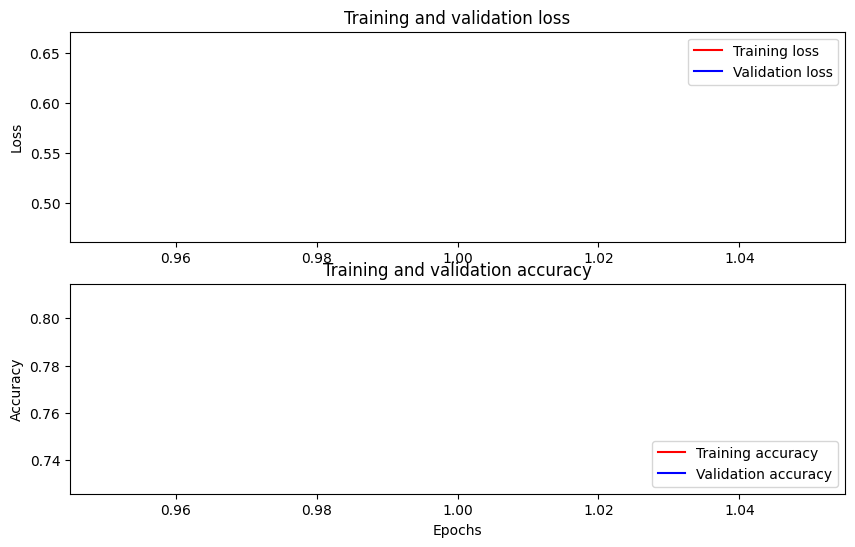

In [126]:
plot_acc_loss(bert_model2.history.history)